## Testing Spatial K-Fold Cross Validation

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../Scripts')
from deafrica_classificationtools import spatial_clusters, SKCV, spatial_train_test_split

%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/osgeo/gdal.py:107: DeprecationWarning: osr.py was placed in a namespace, it is now available as osgeo.osr
  DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Analysis Parameters

In [2]:
training_data = "results/training_data/test_training_data.txt"
coordinate_data = "results/training_data/training_data_coordinates.txt"

cv_splits = 5

n_clusters = 100

test_size = 0.2


### Load data

In [3]:
# load the data
model_input = np.loadtxt(training_data)
coordinates = np.loadtxt(coordinate_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

## Generate spatial clusters to visualize

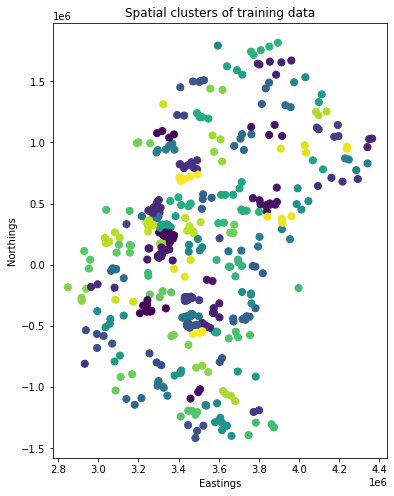

In [4]:
spatial_groups = spatial_clusters(n_clusters, coordinates,
                                  method='GMM', covariance_type='tied')
plt.figure(figsize=(6,8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=spatial_groups,
            s=50, cmap='viridis');
plt.title('Spatial clusters of training data')
plt.ylabel('Northings')
plt.xlabel('Eastings');

## Test the different SKCV methods

In [5]:
#generate n_splits of train-test_splits
kfold = SKCV(X=model_input[:, model_col_indices],
             y=model_input[:, 0],
             coordinates=coordinates,
             n_groups=n_clusters,
             n_splits=cv_splits,
             cluster_method='GMM',
             covariance_type= 'tied',
             kfold_method='SpatialKFold',
             test_size=test_size,
             train_size=None,
             random_state=0,
             balance=True
            )

shuffle = SKCV(X=model_input[:, model_col_indices],
                 y=model_input[:, 0],
                 coordinates=coordinates,
                 n_groups=n_clusters,
                 n_splits=cv_splits,
                 cluster_method='GMM',
                 covariance_type= 'tied',
                 kfold_method='SpatialShuffleSplit',
                 test_size=test_size,
                 train_size=None,
                 random_state=0,
                 balance=10
                )

### Plot train-test coordinate data

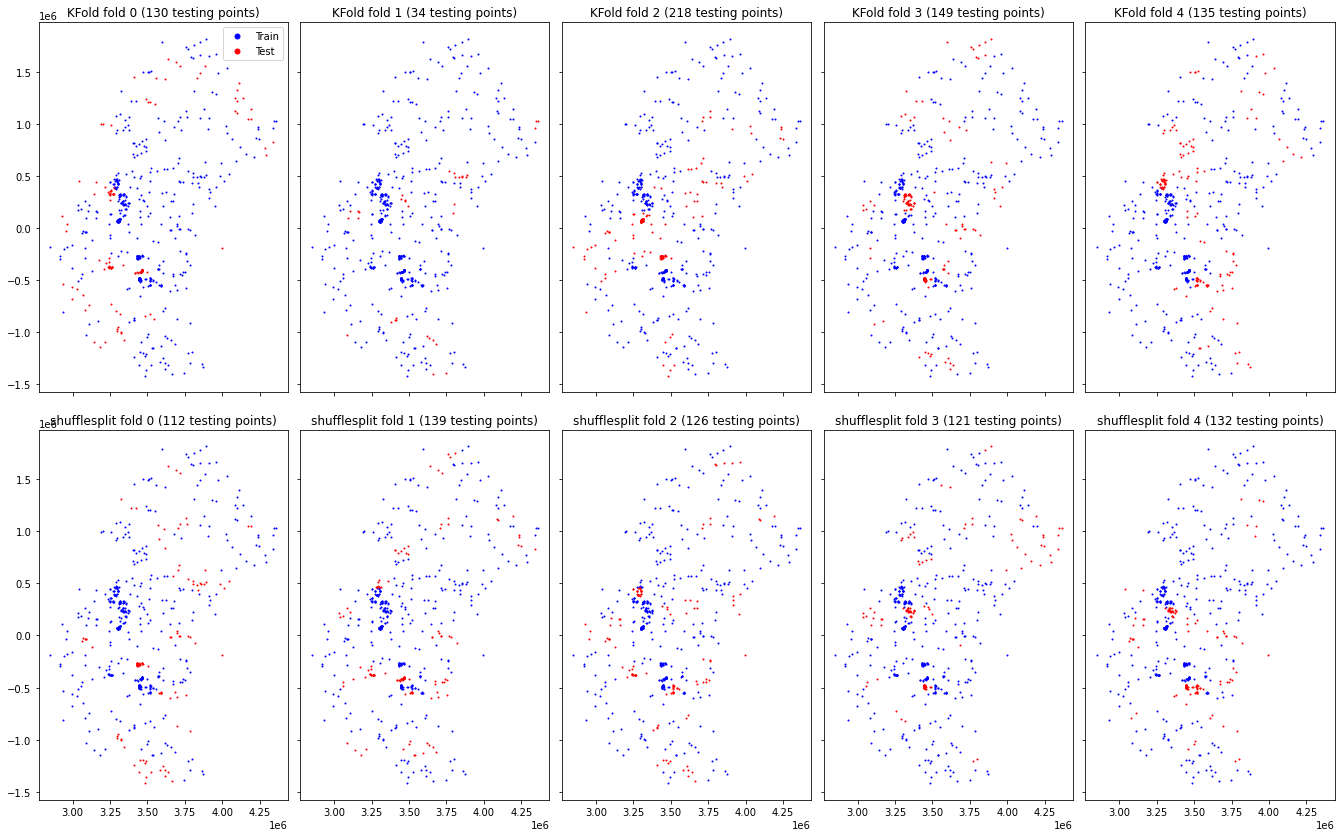

In [6]:
fig, axes = plt.subplots(
    2,
    5,
    figsize=(20, 12),
    sharex=True,
    sharey=True,
)

for row, title, folds in zip(axes, ["KFold",'shufflesplit'], [kfold,shuffle]):
    for i, (ax, fold) in enumerate(zip(row, folds)):
        train, test = fold
        X_tr, X_tt = coordinates[train,:], coordinates[test,:]
        
        ax.set_title("{} fold {} ({} testing points)".format(title, i, test.size))
        ax.plot(
            np.transpose(X_tr)[0],
            np.transpose(X_tr)[1],
            ".b",
            markersize=2,
            label="Train",
        )
        ax.plot(
            np.transpose(X_tt)[0],
            np.transpose(X_tt)[1],
            ".r",
            markersize=2,
            label="Test",
        )
# Place a legend on the first plot
axes[0, 0].legend(loc="upper right", markerscale=5)
plt.subplots_adjust(
    hspace=0.1, wspace=0.05, top=0.95, bottom=0.05, left=0.05, right=0.95
)
plt.show()

## Train-test-split

In [7]:
train_features, test_features, train_labels, test_labels = spatial_train_test_split(X = model_input[:, model_col_indices],
                                                             y = model_input[:, 0],
                                                             coordinates = coordinates,
                                                             n_groups=n_clusters,
                                                             cluster_method='GMM',
                                                             covariance_type= 'tied',
                                                             kfold_method = 'SpatialShuffleSplit',
                                                             test_size=test_size,
                                                             train_size=None,
                                                             balance=True,
                                                             random_state=0
                                                            )

print("train_features shape:", train_features.shape)
print("test_features shape:", test_features.shape)

train_features shape: (556, 15)
test_features shape: (110, 15)


## Train and test a model

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [9]:
model = RandomForestClassifier(random_state=1, n_jobs=2, verbose=0)
model.fit(train_features, train_labels)

RandomForestClassifier(n_jobs=2, random_state=1)

In [10]:
#predict on the test dataset
predictions = model.predict(test_features)

#generate n_splits of train-test_splits
ss = SKCV(X=model_input[:, model_col_indices],
             y=model_input[:, 0],
             coordinates=coordinates,
             n_groups=n_clusters,
             n_splits=cv_splits,
             cluster_method='GMM',
             covariance_type= 'tied',
             kfold_method='SpatialKFold',
             test_size=test_size,
             train_size=None,
             random_state=0,
             balance=True
            )

metric='f1'
# cross validate accounting for spatial groups
score = cross_val_score(model,
                        model_input[:, model_col_indices],
                        model_input[:, 0],
                        cv=ss,
                        scoring=metric
                        )

In [11]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, predictions))
print('\n')
print("=== Overall Accuracy ===")
accuracy = accuracy_score(test_labels, predictions)
print(round(accuracy, 3))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, predictions))
print('\n')
print("=== Spatial K-Fold Cross-Val "+metric+" Scores ===")
print(np.array_str(score, precision=2, suppress_small=True))
print("Mean: "+ str(round(score.mean(), 2)))
print("Std: "+ str(round(score.std(), 2)))

=== Confusion Matrix ===
[[48  9]
 [34 19]]


=== Overall Accuracy ===
0.609


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.59      0.84      0.69        57
         1.0       0.68      0.36      0.47        53

    accuracy                           0.61       110
   macro avg       0.63      0.60      0.58       110
weighted avg       0.63      0.61      0.58       110



=== Spatial K-Fold Cross-Val f1 Scores ===
[0.77 0.79 0.61 0.48 0.68]
Mean: 0.67
Std: 0.11
